device: mps
Epoch 100, loss = 2.324496e-03
Epoch 200, loss = 1.613041e-03
Epoch 300, loss = 1.651701e-03
Epoch 400, loss = 1.697053e-03
Epoch 500, loss = 1.175533e-03
Epoch 600, loss = 1.347520e-03
Epoch 700, loss = 1.325874e-03
Epoch 800, loss = 1.786812e-03
Epoch 900, loss = 1.439661e-03
Epoch 1000, loss = 1.281962e-03
Epoch 1100, loss = 1.332521e-03
Epoch 1200, loss = 1.272062e-03
Epoch 1300, loss = 1.426126e-03
Epoch 1400, loss = 1.140350e-03
Epoch 1500, loss = 1.442559e-03
Epoch 1600, loss = 1.290895e-03
Epoch 1700, loss = 1.532454e-03
Epoch 1800, loss = 1.258178e-03
Epoch 1900, loss = 1.580693e-03
Epoch 2000, loss = 1.368127e-03


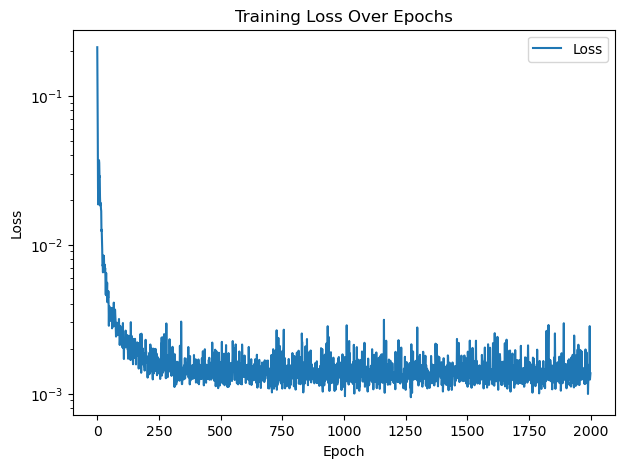

Animation saved as fractional_heat_loss.gif
Mean PDE residual^2 on test batch: 0.0003303841804154217


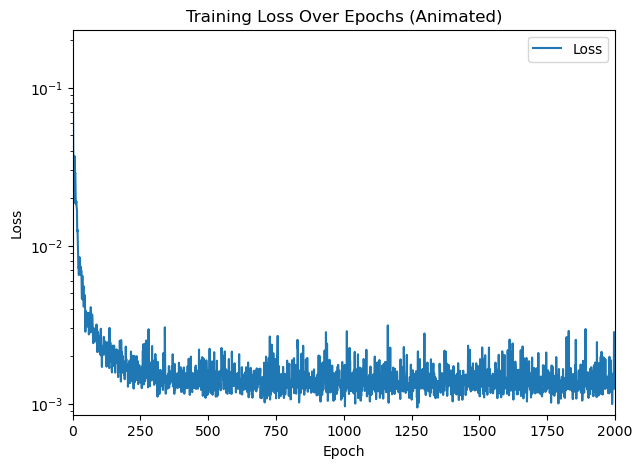

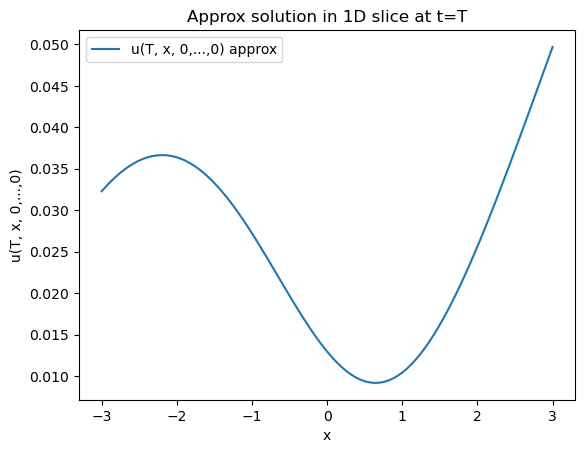

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install "
              "was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    device = torch.device("cpu")  # fallback to CPU
else:
    device = torch.device("mps")  # use Apple Silicon GPU
print("device:", device)

#======================================================================
#                    Problem Setup
#======================================================================

# PDE:  u_t = - ( -Delta )^(alpha/2) u
# in R^{10}, with initial condition u(0,x) = exp(-||x||^2)

alpha = 1.0            # fractional exponent alpha (float)
pde_dimension = 10     # no.of spatial dimensions
T_limit = 1.0          # final time (float)
batch_size = 256       # no. of samples in each training batch
epochs     = 2000      # total training iterations
learning_rate = 1e-3   # initial learning rate

# For PDE: u(0, x) = e^{-||x||^2}
def initial_solution(x):
    # x is (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#======================================================================
#                    Custom Activation 
#======================================================================
class SinActivation(torch.nn.Module):
    """Custom PyTorch activation that applies torch.sin element-wise."""
    def forward(self, x):
        return torch.sin(x)

#---------------------------------------------------------------------
#---------------------------------------------------------------------
#  Monte Carlo approximation of the fractional Laplacian
#  
#  A very rough version of the “principal value” integral:
#     (-Delta)^(alpha/2) u(x)
#   ~  1/M * sum_{i=1..M} [ u(x) - u(y_i) ] / ||x - y_i||^{d+alpha}
#---------------------------------------------------------------------
#---------------------------------------------------------------------
def fractional_laplacian_approx(candidate_fn, t, x, alpha, device, n_samples=100):
    """
    Approximate (-Delta)^(alpha/2) [u(t,.)] at points x.
    Input:
      candidate_fn:  the neural net model,  u_hat(t, x)
      t:  shape (batch_size,) time
      x:  shape (batch_size, pde_dimension) points where we want fractional Laplacian
    Returns a tensor of shape (batch_size,1)
    """
    batch_size = x.shape[0]
    d = x.shape[1]
    M = n_samples

    # Expand t to match the M “y”-points for each x
    t_big = torch.repeat_interleave(t.view(-1,1), M, dim=0)  # shape (batch_size*M, 1)

    # Sample M random points y for each x; use float32
    y = torch.randn(batch_size*M, d, dtype=torch.float32, device=device)

    # Evaluate candidate solution at (t,x) and (t,y)
    x_big = torch.repeat_interleave(x, M, dim=0)  # shape (batch_size*M, d)
    u_x = candidate_fn(torch.cat([t_big, x_big], dim=1))  # shape (batch_size*M, 1)
    u_y = candidate_fn(torch.cat([t_big, y],      dim=1)) # shape (batch_size*M, 1)

    # Compute the Euclidean distance between each x_i and y_j
    diff = x_big - y
    dist_sq = torch.sum(diff * diff, dim=1, keepdim=True)
    dist = torch.sqrt(dist_sq + 1.0e-12)  # avoid sqrt(0)

    # The integrand: [u_x - u_y]/||x-y||^{d+alpha}
    d_plus_alpha = float(d + alpha)
    integrand = (u_x - u_y) / (dist**d_plus_alpha + 1.0e-12)

    # Average over M for each x_i -> shape (batch_size,1)
    integrand_reshaped = integrand.view(batch_size, M, 1)
    frac_lap = integrand_reshaped.mean(dim=1)  

    return frac_lap  

#======================================================================
#                    Loss Functions
#======================================================================
def initial_loss(candidate_fn, random_space_points):
    # t=0, compare candidate solution with e^{-||x||^2}
    t = torch.zeros(random_space_points.shape[0], 1,
                    dtype=torch.float32, device=device)
    candidate_sol = candidate_fn(torch.cat((t, random_space_points), axis=1))
    exact_init = initial_solution(random_space_points)
    return ((candidate_sol - exact_init)**2).mean()

def PDE_residual_loss(candidate_fn, alpha, random_time_points,
                      random_space_points, n_samples=50):
    # random_time_points shape: (batch_size,)
    # random_space_points shape: (batch_size, pde_dimension)
    random_space_points.requires_grad_()
    random_time_points.requires_grad_()

    # candidate_sol(t, x)
    candidate_sol = candidate_fn(torch.cat([random_time_points.unsqueeze(1), 
                                            random_space_points], dim=1))

    # partial_t u(t,x)
    candidate_sol_t = torch.autograd.grad(
        outputs=candidate_sol,
        inputs=random_time_points,
        grad_outputs=torch.ones_like(candidate_sol),
        create_graph=True
    )[0]

    # Approximate fractional Laplacian
    fracLap_candidate = fractional_laplacian_approx(candidate_fn,
                                                    random_time_points,
                                                    random_space_points,
                                                    alpha,
                                                    device,
                                                    n_samples=n_samples)
    # PDE is: u_t = - ( -Delta )^(alpha/2) u
    residual = candidate_sol_t + fracLap_candidate

    return (residual**2).mean()

#======================================================================
#                    Model
#======================================================================
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.normal_(m.bias, std=0.1)

def build_and_return_model(dev, activation, *layer_dims):
    """Construct a fully-connected feedforward NN with given layer sizes."""
    layers = []
    for i in range(len(layer_dims) - 2):
        layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
        layers.append(activation())
    # Last linear
    layers.append(nn.Linear(layer_dims[-2], layer_dims[-1]))
    return nn.Sequential(*layers).to(dev)

# We will build a model that takes (t, x1, x2, ..., x10) as input => outputs scalar
hidden_width = 64
model = build_and_return_model(device, nn.Tanh,
                               pde_dimension+1,  # input size (t + 10 coords)
                               hidden_width,
                               hidden_width,
                               hidden_width,
                               1)  # output size

model.apply(init_weights)

#======================================================================
#                    Optimizer & Scheduler
#======================================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

#======================================================================
#                    Training Loop
#======================================================================
loss_history = []

for epoch in range(epochs):
    # sample random points in time & space in float32
    t = T_limit * torch.rand(batch_size, dtype=torch.float32, device=device)
    x = torch.randn(batch_size, pde_dimension, dtype=torch.float32, device=device)

    # compute losses
    loss_init = initial_loss(model, x)
    loss_pde  = PDE_residual_loss(model, alpha, t, x, n_samples=50)
    loss = loss_init + loss_pde

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, loss = {loss.item():.6e}")

#======================================================================
#                    Visualize Loss
#======================================================================
plt.figure(figsize=(7,5))
plt.plot(loss_history, label="Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

#---------------------------
# Optionally, animate loss:
#---------------------------
fig, ax = plt.subplots(figsize=(7, 5))
line, = ax.plot([], [], label="Loss")
ax.set_title("Training Loss Over Epochs (Animated)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()

ax.set_xlim(0, len(loss_history))
ax.set_ylim(min(loss_history)*0.9, max(loss_history)*1.1)

def update(frame):
    x_data = np.arange(frame + 1)
    y_data = loss_history[:frame + 1]
    line.set_data(x_data, y_data)
    return line,

ani = FuncAnimation(fig, update, frames=len(loss_history), blit=True)
ani.save("fractional_heat_loss.gif", writer="pillow", fps=10)
print("Animation saved as fractional_heat_loss.gif")

#======================================================================
#                    Residual Check
#======================================================================
def check_pde_residual(model, alpha, num_points=512):
    model.eval()
    t_test = T_limit * torch.rand(num_points, dtype=torch.float32, device=device)
    x_test = torch.randn(num_points, pde_dimension, dtype=torch.float32, device=device)

    # DO NOT wrap PDE_residual_loss in no_grad, because we need derivatives
    res_mse_tensor = PDE_residual_loss(model, alpha, t_test, x_test, n_samples=50)
    res_mse = res_mse_tensor.item()

    print("Mean PDE residual^2 on test batch:", res_mse)
    return res_mse

residual_mse = check_pde_residual(model, alpha)

#======================================================================
#            1D Slice Plot:  u(T, (x, 0, ..., 0)) vs. x
#======================================================================
def evaluate_model_1d_slice(model, T_val, x_vals_1d, pde_dimension, device):
    """
    Evaluate the trained model at t = T_val and
    x = (x1, 0, 0, ..., 0) for each x1 in x_vals_1d.
    
    Returns: 1D NumPy array of model outputs.
    """
    # Ensure x_vals_1d is float32
    if x_vals_1d.dtype != np.float32:
        x_vals_1d = x_vals_1d.astype(np.float32)
    
    # Create an (N, pde_dimension) array of zeros in float32
    x_tensor = torch.zeros(len(x_vals_1d), pde_dimension,
                           dtype=torch.float32, device=device)
    x_tensor[:, 0] = torch.tensor(x_vals_1d, dtype=torch.float32, device=device)

    # Create the time entries
    t_tensor = T_val * torch.ones(len(x_vals_1d), 1,
                                  dtype=torch.float32, device=device)

    # Combine [t, x] into a single input
    input_tensor = torch.cat([t_tensor, x_tensor], dim=1)  # shape (N, 1 + pde_dimension)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        u_vals = model(input_tensor).cpu().numpy().ravel()

    return u_vals

# Produce a 1D slice plot at t = T_limit
# Make sure x_range is also float32
x_range = np.linspace(-3, 3, 100, dtype=np.float32)
u_approx_1d = evaluate_model_1d_slice(model, T_limit, x_range, pde_dimension, device)

plt.figure()
plt.plot(x_range, u_approx_1d, label="u(T, x, 0,...,0) approx")
plt.title("Approx solution in 1D slice at t=T")
plt.xlabel("x")
plt.ylabel("u(T, x, 0,...,0)")
plt.legend()
plt.show()


device: mps
Epoch 100, loss = 2.695678e-03
Epoch 200, loss = 2.288466e-03
Epoch 300, loss = 1.734618e-03
Epoch 400, loss = 1.575192e-03
Epoch 500, loss = 1.704570e-03
Epoch 600, loss = 1.583327e-03
Epoch 700, loss = 1.817498e-03
Epoch 800, loss = 1.526845e-03
Epoch 900, loss = 1.797112e-03
Epoch 1000, loss = 1.743522e-03
Epoch 1100, loss = 1.957593e-03
Epoch 1200, loss = 1.572907e-03
Epoch 1300, loss = 1.358492e-03
Epoch 1400, loss = 1.463388e-03
Epoch 1500, loss = 1.884043e-03
Epoch 1600, loss = 1.798274e-03
Epoch 1700, loss = 1.581748e-03
Epoch 1800, loss = 1.789522e-03
Epoch 1900, loss = 1.764385e-03
Epoch 2000, loss = 2.352249e-03


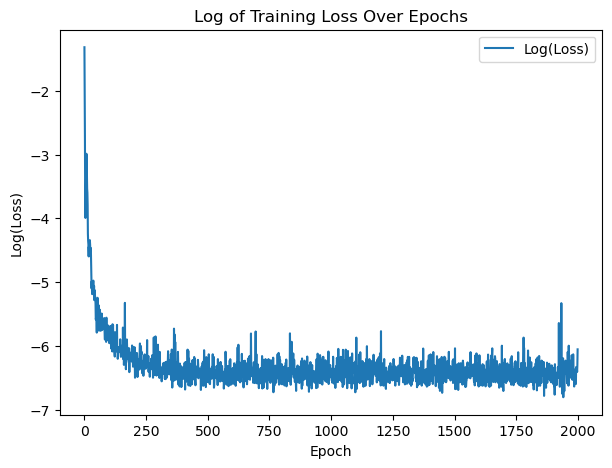

Animation saved as fractional_heat_log_loss.gif
Mean PDE residual^2 on test batch: 0.00029586744494736195


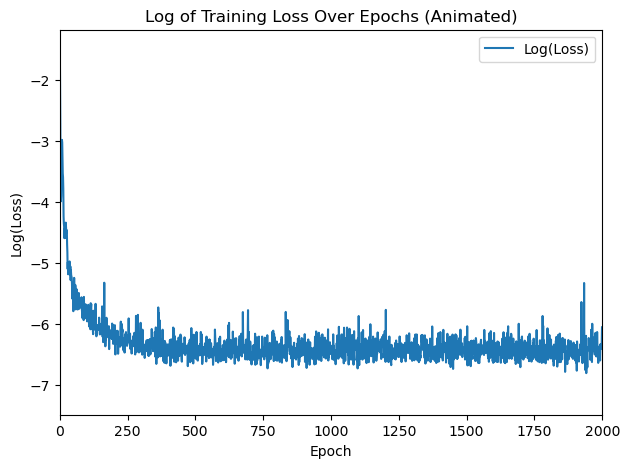

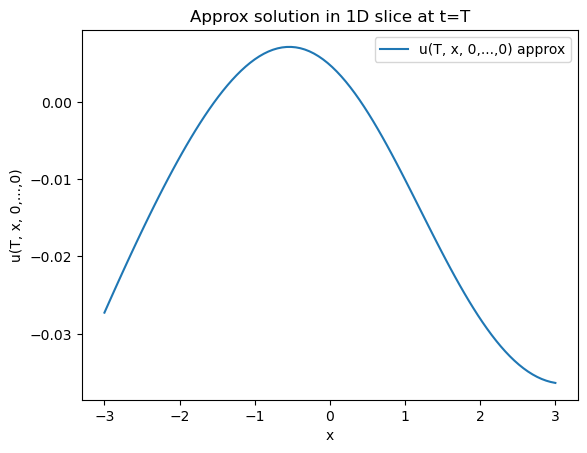

Test data saved to test_data.json. (num_points=100)
Approximate solution saved to approx_solution.json. (num_points=100)


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import json
import os

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install "
              "was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    device = torch.device("cpu")  # fallback to CPU
else:
    device = torch.device("mps")  # use Apple Silicon GPU
print("device:", device)

#======================================================================
#                    Problem Setup
#======================================================================

alpha = 1.5            # fractional exponent alpha (float)
pde_dimension = 10     # number of spatial dimensions
T_limit = 1.0          # final time (float)
batch_size = 256       # how many samples in each training batch
epochs     = 2000      # total training iterations
learning_rate = 1e-3   # initial learning rate

def initial_solution(x):
    # x is (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#======================================================================
#                    Custom Activation (Optional)
#======================================================================
class SinActivation(torch.nn.Module):
    """Custom PyTorch activation that applies torch.sin element-wise."""
    def forward(self, x):
        return torch.sin(x)

#---------------------------------------------------------------------
#  Monte Carlo approximation of the fractional Laplacian
#---------------------------------------------------------------------
def fractional_laplacian_approx(candidate_fn, t, x, alpha, device, n_samples=100):
    """
    Approximate (-Delta)^(alpha/2) [u(t,.)] at points x.
      - candidate_fn: The neural net model,  u_hat(t, x)
      - t:  shape (batch_size,) time
      - x:  shape (batch_size, pde_dimension) points where we want fractional Laplacian
    Returns: (batch_size,1) tensor
    """
    batch_size = x.shape[0]
    d = x.shape[1]
    M = n_samples

    # Expand t to match the M “y”-points for each x
    t_big = torch.repeat_interleave(t.view(-1,1), M, dim=0)  # shape (batch_size*M, 1)

    # Sample M random points y for each x
    y = torch.randn(batch_size*M, d, dtype=torch.float32, device=device)

    # Evaluate candidate solution at (t,x) and (t,y)
    x_big = torch.repeat_interleave(x, M, dim=0)  # shape (batch_size*M, d)
    u_x = candidate_fn(torch.cat([t_big, x_big], dim=1))  # shape (batch_size*M, 1)
    u_y = candidate_fn(torch.cat([t_big, y],      dim=1)) # shape (batch_size*M, 1)

    # Compute the Euclidean distance between each x_i and y_j
    diff = x_big - y
    dist_sq = torch.sum(diff * diff, dim=1, keepdim=True)
    dist = torch.sqrt(dist_sq + 1.0e-12)  # avoid sqrt(0)

    # The integrand: [u_x - u_y]/||x-y||^{d+alpha}
    d_plus_alpha = float(d + alpha)
    integrand = (u_x - u_y) / (dist**d_plus_alpha + 1.0e-12)

    # Average over M for each x_i -> shape (batch_size,1)
    integrand_reshaped = integrand.view(batch_size, M, 1)
    frac_lap = integrand_reshaped.mean(dim=1)  

    return frac_lap  

#======================================================================
#                    Loss Functions
#======================================================================
def initial_loss(candidate_fn, random_space_points):
    # t=0, compare candidate solution with e^{-||x||^2}
    t = torch.zeros(random_space_points.shape[0], 1,
                    dtype=torch.float32, device=device)
    candidate_sol = candidate_fn(torch.cat((t, random_space_points), axis=1))
    exact_init = initial_solution(random_space_points)
    return ((candidate_sol - exact_init)**2).mean()

def PDE_residual_loss(candidate_fn, alpha, random_time_points,
                      random_space_points, n_samples=50):
    # random_time_points shape: (batch_size,)
    # random_space_points shape: (batch_size, pde_dimension)
    random_space_points.requires_grad_()
    random_time_points.requires_grad_()

    # candidate_sol(t, x)
    candidate_sol = candidate_fn(torch.cat([random_time_points.unsqueeze(1), 
                                            random_space_points], dim=1))

    # partial_t u(t,x)
    candidate_sol_t = torch.autograd.grad(
        outputs=candidate_sol,
        inputs=random_time_points,
        grad_outputs=torch.ones_like(candidate_sol),
        create_graph=True
    )[0]

    # Approximate fractional Laplacian
    fracLap_candidate = fractional_laplacian_approx(candidate_fn,
                                                    random_time_points,
                                                    random_space_points,
                                                    alpha,
                                                    device,
                                                    n_samples=n_samples)
    # PDE is: u_t = - ( -Delta )^(alpha/2) u
    residual = candidate_sol_t + fracLap_candidate

    return (residual**2).mean()

#======================================================================
#                    Model
#======================================================================
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.normal_(m.bias, std=0.1)

def build_and_return_model(dev, activation, *layer_dims):
    """Construct a fully-connected feedforward NN with given layer sizes."""
    layers = []
    for i in range(len(layer_dims) - 2):
        layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
        layers.append(activation())
    # Last linear
    layers.append(nn.Linear(layer_dims[-2], layer_dims[-1]))
    return nn.Sequential(*layers).to(dev)

# Construct a model that takes (t, x1, x2, ..., x10) as input => outputs scalar
hidden_width = 64
model = build_and_return_model(device, nn.Tanh,
                               pde_dimension+1,  # input size (t + 10 coords)
                               hidden_width,
                               hidden_width,
                               hidden_width,
                               1)  # output size

model.apply(init_weights)

#======================================================================
#                    Optimizer & Scheduler
#======================================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

#======================================================================
#                    Training Loop
#======================================================================
loss_history = []

for epoch in range(epochs):
    # sample random points in time & space in float32
    t = T_limit * torch.rand(batch_size, dtype=torch.float32, device=device)
    x = torch.randn(batch_size, pde_dimension, dtype=torch.float32, device=device)

    # compute losses
    loss_init = initial_loss(model, x)
    loss_pde  = PDE_residual_loss(model, alpha, t, x, n_samples=50)
    loss = loss_init + loss_pde

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, loss = {loss.item():.6e}")

#======================================================================
#                    Visualize Loss
#======================================================================
# plt.figure(figsize=(7,5))
# plt.plot(loss_history, label="Loss")
# plt.title("Training Loss Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.yscale("log")
# plt.legend()
# plt.show()

#---------------------------
# Optionally, animate loss:
#---------------------------
# fig, ax = plt.subplots(figsize=(7, 5))
# line, = ax.plot([], [], label="Loss")
# ax.set_title("Training Loss Over Epochs (Animated)")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Loss")
# ax.set_yscale("log")
# ax.legend()

# ax.set_xlim(0, len(loss_history))
# ax.set_ylim(min(loss_history)*0.9, max(loss_history)*1.1)

# def update(frame):
#     x_data = np.arange(frame + 1)
#     y_data = loss_history[:frame + 1]
#     line.set_data(x_data, y_data)
#     return line,

# ani = FuncAnimation(fig, update, frames=len(loss_history), blit=True)
# ani.save("fractional_heat_loss.gif", writer="pillow", fps=10)
# print("Animation saved as fractional_heat_loss.gif")

plt.figure(figsize=(7,5))
plt.plot(np.log(loss_history), label="Log(Loss)")
plt.title("Log of Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")
plt.legend()
plt.show()

#---------------------------
# Optionally, animate Log(loss):
#---------------------------
fig, ax = plt.subplots(figsize=(7, 5))
line, = ax.plot([], [], label="Log(Loss)")
ax.set_title("Log of Training Loss Over Epochs (Animated)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Log(Loss)")
ax.legend()

ax.set_xlim(0, len(loss_history))
ax.set_ylim(min(np.log(loss_history))*1.1, max(np.log(loss_history))*0.9)

def update(frame):
    x_data = np.arange(frame + 1)
    y_data = np.log(loss_history[:frame + 1])
    line.set_data(x_data, y_data)
    return line,

ani = FuncAnimation(fig, update, frames=len(loss_history), blit=True)
ani.save("fractional_heat_log_loss.gif", writer="pillow", fps=10)
print("Animation saved as fractional_heat_log_loss.gif")


#======================================================================
#                    Residual Check
#======================================================================
def check_pde_residual(model, alpha, num_points=512):
    model.eval()
    t_test = T_limit * torch.rand(num_points, dtype=torch.float32, device=device)
    x_test = torch.randn(num_points, pde_dimension, dtype=torch.float32, device=device)

    # DO NOT wrap PDE_residual_loss in no_grad, because we need derivatives
    res_mse_tensor = PDE_residual_loss(model, alpha, t_test, x_test, n_samples=50)
    res_mse = res_mse_tensor.item()

    print("Mean PDE residual^2 on test batch:", res_mse)
    return res_mse

residual_mse = check_pde_residual(model, alpha)

#======================================================================
#            1D Slice Plot:  u(T, (x, 0, ..., 0)) vs. x
#======================================================================
def evaluate_model_1d_slice(model, T_val, x_vals_1d, pde_dimension, device):
    """
    Evaluate the trained model at t = T_val and
    x = (x1, 0, 0, ..., 0) for each x1 in x_vals_1d.
    
    Returns: 1D NumPy array of model outputs.
    """
    # Ensure x_vals_1d is float32
    if x_vals_1d.dtype != np.float32:
        x_vals_1d = x_vals_1d.astype(np.float32)
    
    # Create an (N, pde_dimension) array of zeros in float32
    x_tensor = torch.zeros(len(x_vals_1d), pde_dimension,
                           dtype=torch.float32, device=device)
    x_tensor[:, 0] = torch.tensor(x_vals_1d, dtype=torch.float32, device=device)

    # Create the time entries
    t_tensor = T_val * torch.ones(len(x_vals_1d), 1,
                                  dtype=torch.float32, device=device)

    # Combine [t, x] into a single input
    input_tensor = torch.cat([t_tensor, x_tensor], dim=1)  # shape (N, 1 + pde_dimension)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        u_vals = model(input_tensor).cpu().numpy().ravel()

    return u_vals

# Produce a 1D slice plot at t = T_limit
x_range = np.linspace(-3, 3, 100, dtype=np.float32)
u_approx_1d = evaluate_model_1d_slice(model, T_limit, x_range, pde_dimension, device)

plt.figure()
plt.plot(x_range, u_approx_1d, label="u(T, x, 0,...,0) approx")
plt.title("Approx solution in 1D slice at t=T")
plt.xlabel("x")
plt.ylabel("u(T, x, 0,...,0)")
plt.legend()
plt.show()

#======================================================================
#                1) Generate & Save Test Data to JSON
#======================================================================
def generate_and_save_test_data(num_points, pde_dimension, T_limit, filename='test_data.json'):
    """
    Generate random test data (time and space) and save as JSON.
    - num_points: Number of test points to generate
    - pde_dimension: Dimensionality of spatial domain
    - T_limit: Maximum time
    - filename: JSON file name to save the data
    """
    # Generate random time in [0, T_limit]
    t_np = T_limit * np.random.rand(num_points).astype(np.float32)
    # Generate random space from a normal distribution
    x_np = np.random.randn(num_points, pde_dimension).astype(np.float32)
    
    # Convert arrays to lists for JSON serialization
    data_dict = {
        "t": t_np.tolist(),
        "x": x_np.tolist()
    }
    # Save to JSON
    with open(filename, 'w') as f:
        json.dump(data_dict, f)
    
    print(f"Test data saved to {filename}. (num_points={num_points})")


#======================================================================
#      2) Load Test Data (as arrays) & Compute Approx Solution
#======================================================================
def compute_approx_solution_from_test_data(model, device,
                                           t_data_np, x_data_np,
                                           out_filename='approx_solution.json'):
    """
    Given arrays of time and space data, compute the approximate solution
    from the trained model and store the result in a JSON file.
    - model: trained neural network
    - device: PyTorch device (cpu/gpu/mps)
    - t_data_np: 1D NumPy array of shape (N,)
    - x_data_np: 2D NumPy array of shape (N, pde_dimension)
    - out_filename: File name to store the solution
    Returns: approximate solution as a 1D NumPy array
    """
    # Convert input data to tensors
    t_tensor = torch.tensor(t_data_np, dtype=torch.float32, device=device).unsqueeze(1)
    x_tensor = torch.tensor(x_data_np, dtype=torch.float32, device=device)
    
    # Combine [t, x] => shape (N, 1 + pde_dimension)
    input_tensor = torch.cat([t_tensor, x_tensor], dim=1)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        u_approx = model(input_tensor).cpu().numpy().ravel()  # shape (N,)

    # Store solution in JSON
    # Convert to list for JSON serialization
    solution_dict = {
        "u_approx": u_approx.tolist()
    }
    with open(out_filename, 'w') as f:
        json.dump(solution_dict, f)

    print(f"Approximate solution saved to {out_filename}. (num_points={len(u_approx)})")
    return u_approx


# -------------------------
# Example usage of the new functions:
# -------------------------
# 1) Generate test data set
generate_and_save_test_data(num_points=100,  # for example
                            pde_dimension=pde_dimension,
                            T_limit=T_limit,
                            filename="test_data.json")

# 2) Suppose in your actual script, you might read it back or already have the arrays.
#    For demonstration, let's just load them back into Python from the JSON file:
with open("test_data.json", 'r') as f:
    test_data = json.load(f)

# Convert the JSON lists back to NumPy arrays
t_data_np = np.array(test_data["t"], dtype=np.float32)
x_data_np = np.array(test_data["x"], dtype=np.float32)

# 3) Compute approximate solution using the newly created function
approx_solution = compute_approx_solution_from_test_data(
    model, device, t_data_np, x_data_np, out_filename="approx_solution.json"
)
